In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import colors
import matplotlib.ticker as ticker
import scipy.stats
import sys
sys.path.append('..')
sys.path.append('../lib')
from lib import *

plt.style.use('../peptidome.mplstyle')
from lib.plotting import model_labels as labels


import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import json
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

## For the original analayses and data derivation see https://github.com/andim/peptidome/tree/master/code/nndist, especially response_vs_distance.ipynb and https://github.com/andim/peptidome/blob/master/code/maxent/, especially malaria_analysis.ipynb

In [5]:
datadir = '../data/generated_data'
figdatadir ='../data/Figure Data'

In [7]:
response_df = pd.read_csv(f'{figdatadir}/response_vs_distance.csv')

In [8]:
response_df

,nndist,mean,count
0,0,0.045455,22
1,1,0.261682,107
2,2,0.256919,2421
3,3,0.199430,3510


In [9]:
ps = np.array(response_df['mean'])
ns = np.array(response_df['count'])

In [11]:
test = statsmodels.stats.proportion.proportions_chisquare_allpairs(ps*ns, ns)
list(zip(test.all_pairs, test.pval_corrected()))

[((np.int64(0), np.int64(1)), np.float64(0.11207735267750049)),
 ((np.int64(0), np.int64(2)), np.float64(0.11207735267750049)),
 ((np.int64(0), np.int64(3)), np.float64(0.19839264331892242)),
 ((np.int64(1), np.int64(2)), np.float64(0.912144377818153)),
 ((np.int64(1), np.int64(3)), np.float64(0.21434256387314266)),
 ((np.int64(2), np.int64(3)), np.float64(1.0254004088381143e-06))]

In [13]:
response_df['observed'] = response_df.apply(lambda row: row['mean']*row['count'],axis=1)

In [14]:
response_df

,nndist,mean,count,observed
0,0,0.045455,22,1.0
1,1,0.261682,107,28.0
2,2,0.256919,2421,622.0
3,3,0.199430,3510,700.0


In [15]:
close = response_df[response_df['nndist']!=3].sum()[['count', 'observed']]
far = response_df[response_df['nndist']==3].sum()[['count', 'observed']]

In [16]:
close

count       2550.0
observed     651.0
dtype: float64

In [17]:
100*close['observed']/close['count']

np.float64(25.529411764705888)

In [18]:
far

count       3510.0
observed     700.0
dtype: float64

In [19]:
100*far['observed']/far['count']

np.float64(19.943019943019937)

In [20]:
arg1 = np.array([close['observed'],far['observed']])
arg2 = np.array([close['count'],far['count']])

In [21]:

stat, pval = statsmodels.stats.proportion.proportions_ztest(arg1,arg2)


In [22]:
pval

np.float64(2.4931691571729094e-07)

In [23]:
with open(f'{figdatadir}/malaria_pdf.json','r') as ff:
    density_dict = json.load(ff)

In [24]:
density_dict.keys()

dict_keys(['Human Peptidome', 'Malaria Peptidome', 'Malaria Epitopes', 'Malaria Epitopes (-)'])

In [25]:
order = ['Human Peptidome', 'Malaria Peptidome', 'Malaria Epitopes (-)', 'Malaria Epitopes']
source_mapper = {
    'Malaria Peptidome': 'Malaria Peptides',
    'Malaria Epitopes (-)': 'Non-Immunogenic Epitopes',
    'Malaria Epitopes (+)': 'Immunogenic Epitopes',

}

In [26]:
distances_df = pd.read_csv(f'{figdatadir}/malaria_distances.csv')
distances_df['source'] = distances_df['source'].apply(source_mapper.get)

In [27]:
distances_df

,Unnamed: 0,distance_bin,source,value,distance
0,0,0,Malaria Peptides,0.003250,0
1,1,1,Malaria Peptides,0.022360,1
2,2,2,Malaria Peptides,0.379320,2
3,3,3,Malaria Peptides,0.595070,3+
4,4,0,Non-Immunogenic Epitopes,0.000000,0
5,5,1,Non-Immunogenic Epitopes,0.055556,1
6,6,2,Non-Immunogenic Epitopes,0.333333,2
7,7,3,Non-Immunogenic Epitopes,0.611111,3+
8,8,0,Immunogenic Epitopes,0.000000,0
9,9,1,Immunogenic Epitopes,0.023810,1


In [28]:
source_mapper.values()

dict_values(['Malaria Peptides', 'Non-Immunogenic Epitopes', 'Immunogenic Epitopes'])

In [29]:
rows = []
for i, source in enumerate(distances_df['source'].unique()):
    x = np.array(range(2))
    y = np.squeeze(distances_df[(distances_df['source']==source)&(distances_df['distance']=='3+')]['value'])
    rows.append({
        'source': source,
        'distance': '<=2',
        'value': 1-y,
    })
    rows.append({
        'source': source,
        'distance': '>3',
        'value': y

    })
collapsed_df = pd.DataFrame(data=rows)

In [30]:
total_df = collapsed_df.groupby(by=['source']).sum()[['value']]

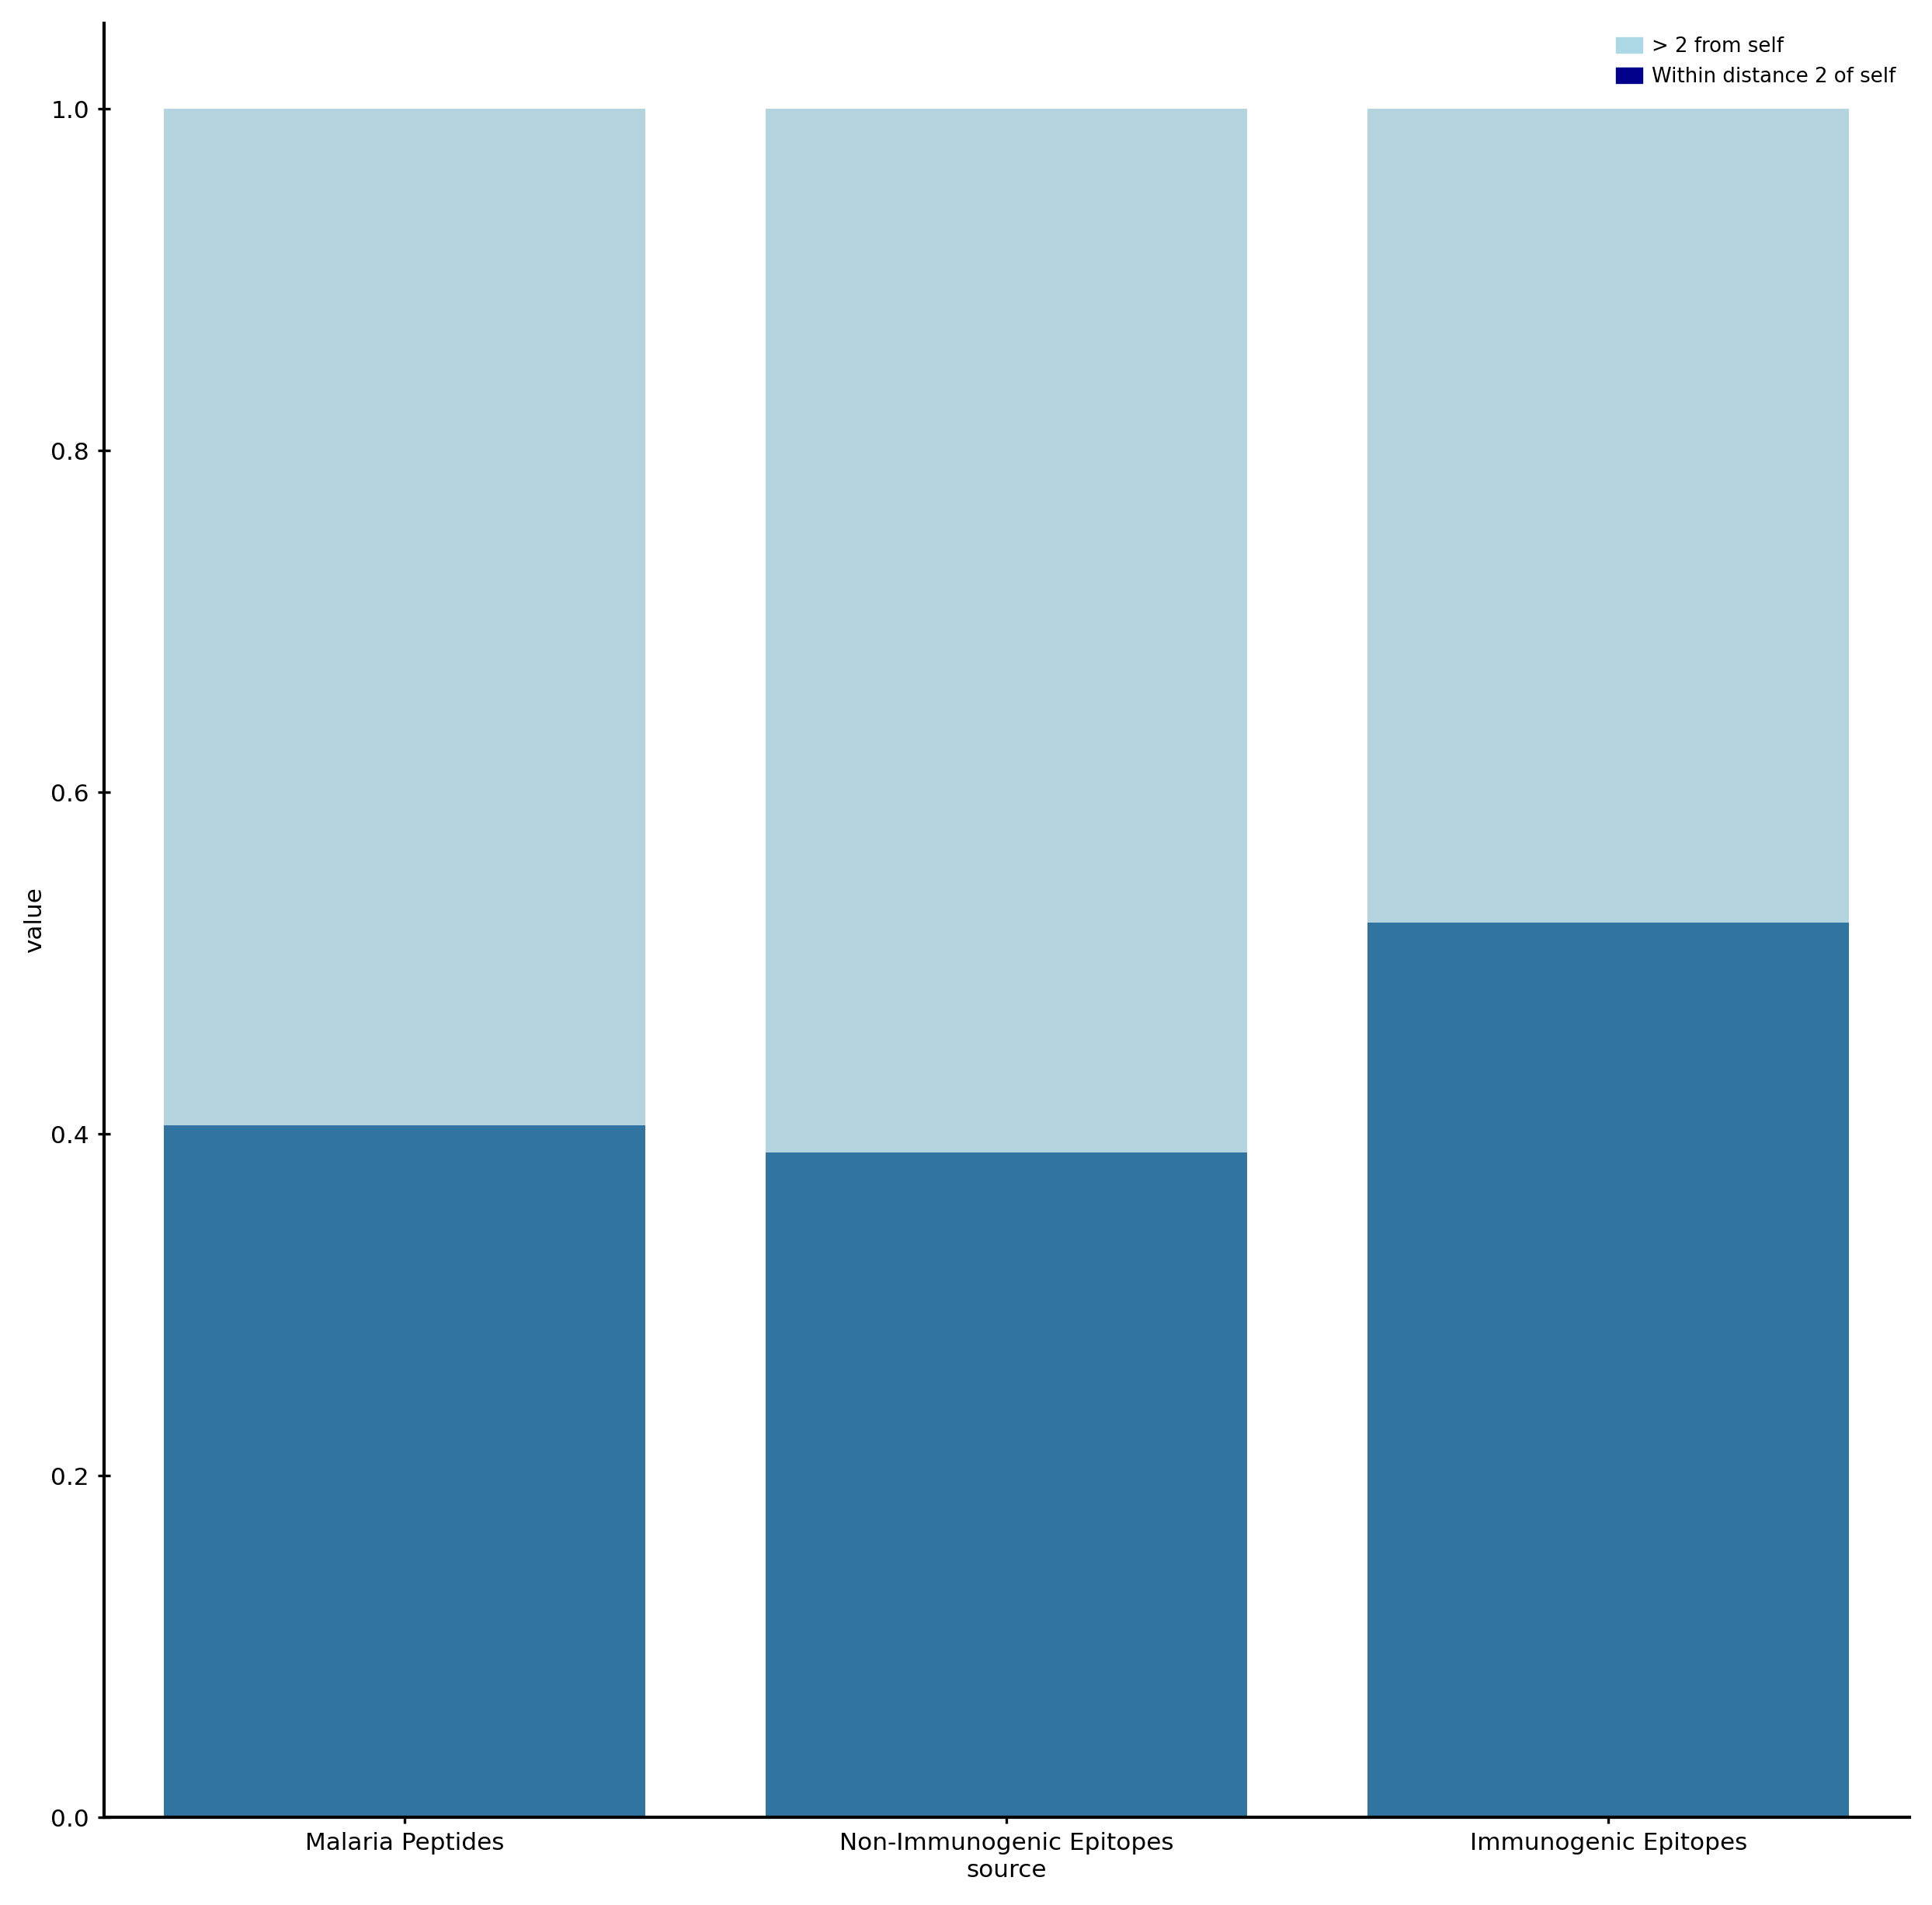

In [31]:
plt.figure(figsize=(10,10))
# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="source",  y="value", data=total_df, color='lightblue',order=list(source_mapper.values()))

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="source", y="value", data=collapsed_df[collapsed_df['distance']=='<=2'], color='#1f77b4',order=list(source_mapper.values()))

# add legend
bottom_bar = mpatches.Patch(color='darkblue', label='Within distance 2 of self')
top_bar = mpatches.Patch(color='lightblue', label='> 2 from self')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

In [32]:
# full data for statistical test
with open(f'{datadir}/malaria_distance_to_self.json','r') as f:
    full_distances_data = json.load(f)

In [33]:
full_distances_data

{'malaria': [325, 2236, 37932, 59507],
 'epitopes': [0, 3, 28, 28],
 'epitope_source': [0, 129, 2100, 1831],
 'epitope_elispot': [0, 1, 21, 20],
 'epitope_source_elispot': [0, 127, 2011, 1785],
 'null': [1, 365, 18931, 80703],
 'epitope_negative': [0, 4, 16, 36],
 'epitope_negative_elispot': [0, 2, 12, 22]}

In [34]:
test_p = []
test_n = []
for source in ['malaria', 'epitopes']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)

test_p = []
test_n = []
for source in ['epitope_negative', 'epitopes']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
    
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)


test_p = []
test_n = []
for source in ['epitope_negative', 'malaria']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
    
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)


0.02972522107621781
0.034713167589419294
0.23321304185523178


In [35]:
test_p = []
test_n = []
for source in ['malaria', 'epitope_elispot']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)

test_p = []
test_n = []
for source in ['epitope_negative_elispot', 'epitope_elispot']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
    
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)


test_p = []
test_n = []
for source in ['epitope_negative_elispot', 'malaria']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    test_p.append(p)
    test_n.append(n)
    
stat, pval = statsmodels.stats.proportion.proportions_ztest(np.array(test_p)*np.array(test_n), np.array(test_n),alternative='smaller')
print(pval)


0.05830922962993569
0.11671165488848478
0.4222912256967833


In [36]:
source_mapper = {
    'malaria': 'Malaria Peptides',
    'epitope_negative': 'Non-Immunogenic Epitopes',
    'epitopes': 'Immunogenic Epitopes',

}
rows = []
total_rows = []

for source in ['malaria', 'epitope_negative', 'epitopes']:
    ds = full_distances_data[source]
    n = sum(ds)
    p = sum(ds[:-1])/n
    
    rows.append({
        'source': source_mapper[source],
        'value': p
        
    })
    total_rows.append({
        'source': source_mapper[source],
        'value': 1
        
    })
close_to_self_df = pd.DataFrame(data=rows)
total_df = pd.DataFrame(data=total_rows)

In [37]:
close_to_self_df

,source,value
0,Malaria Peptides,0.404930
1,Non-Immunogenic Epitopes,0.357143
2,Immunogenic Epitopes,0.525424


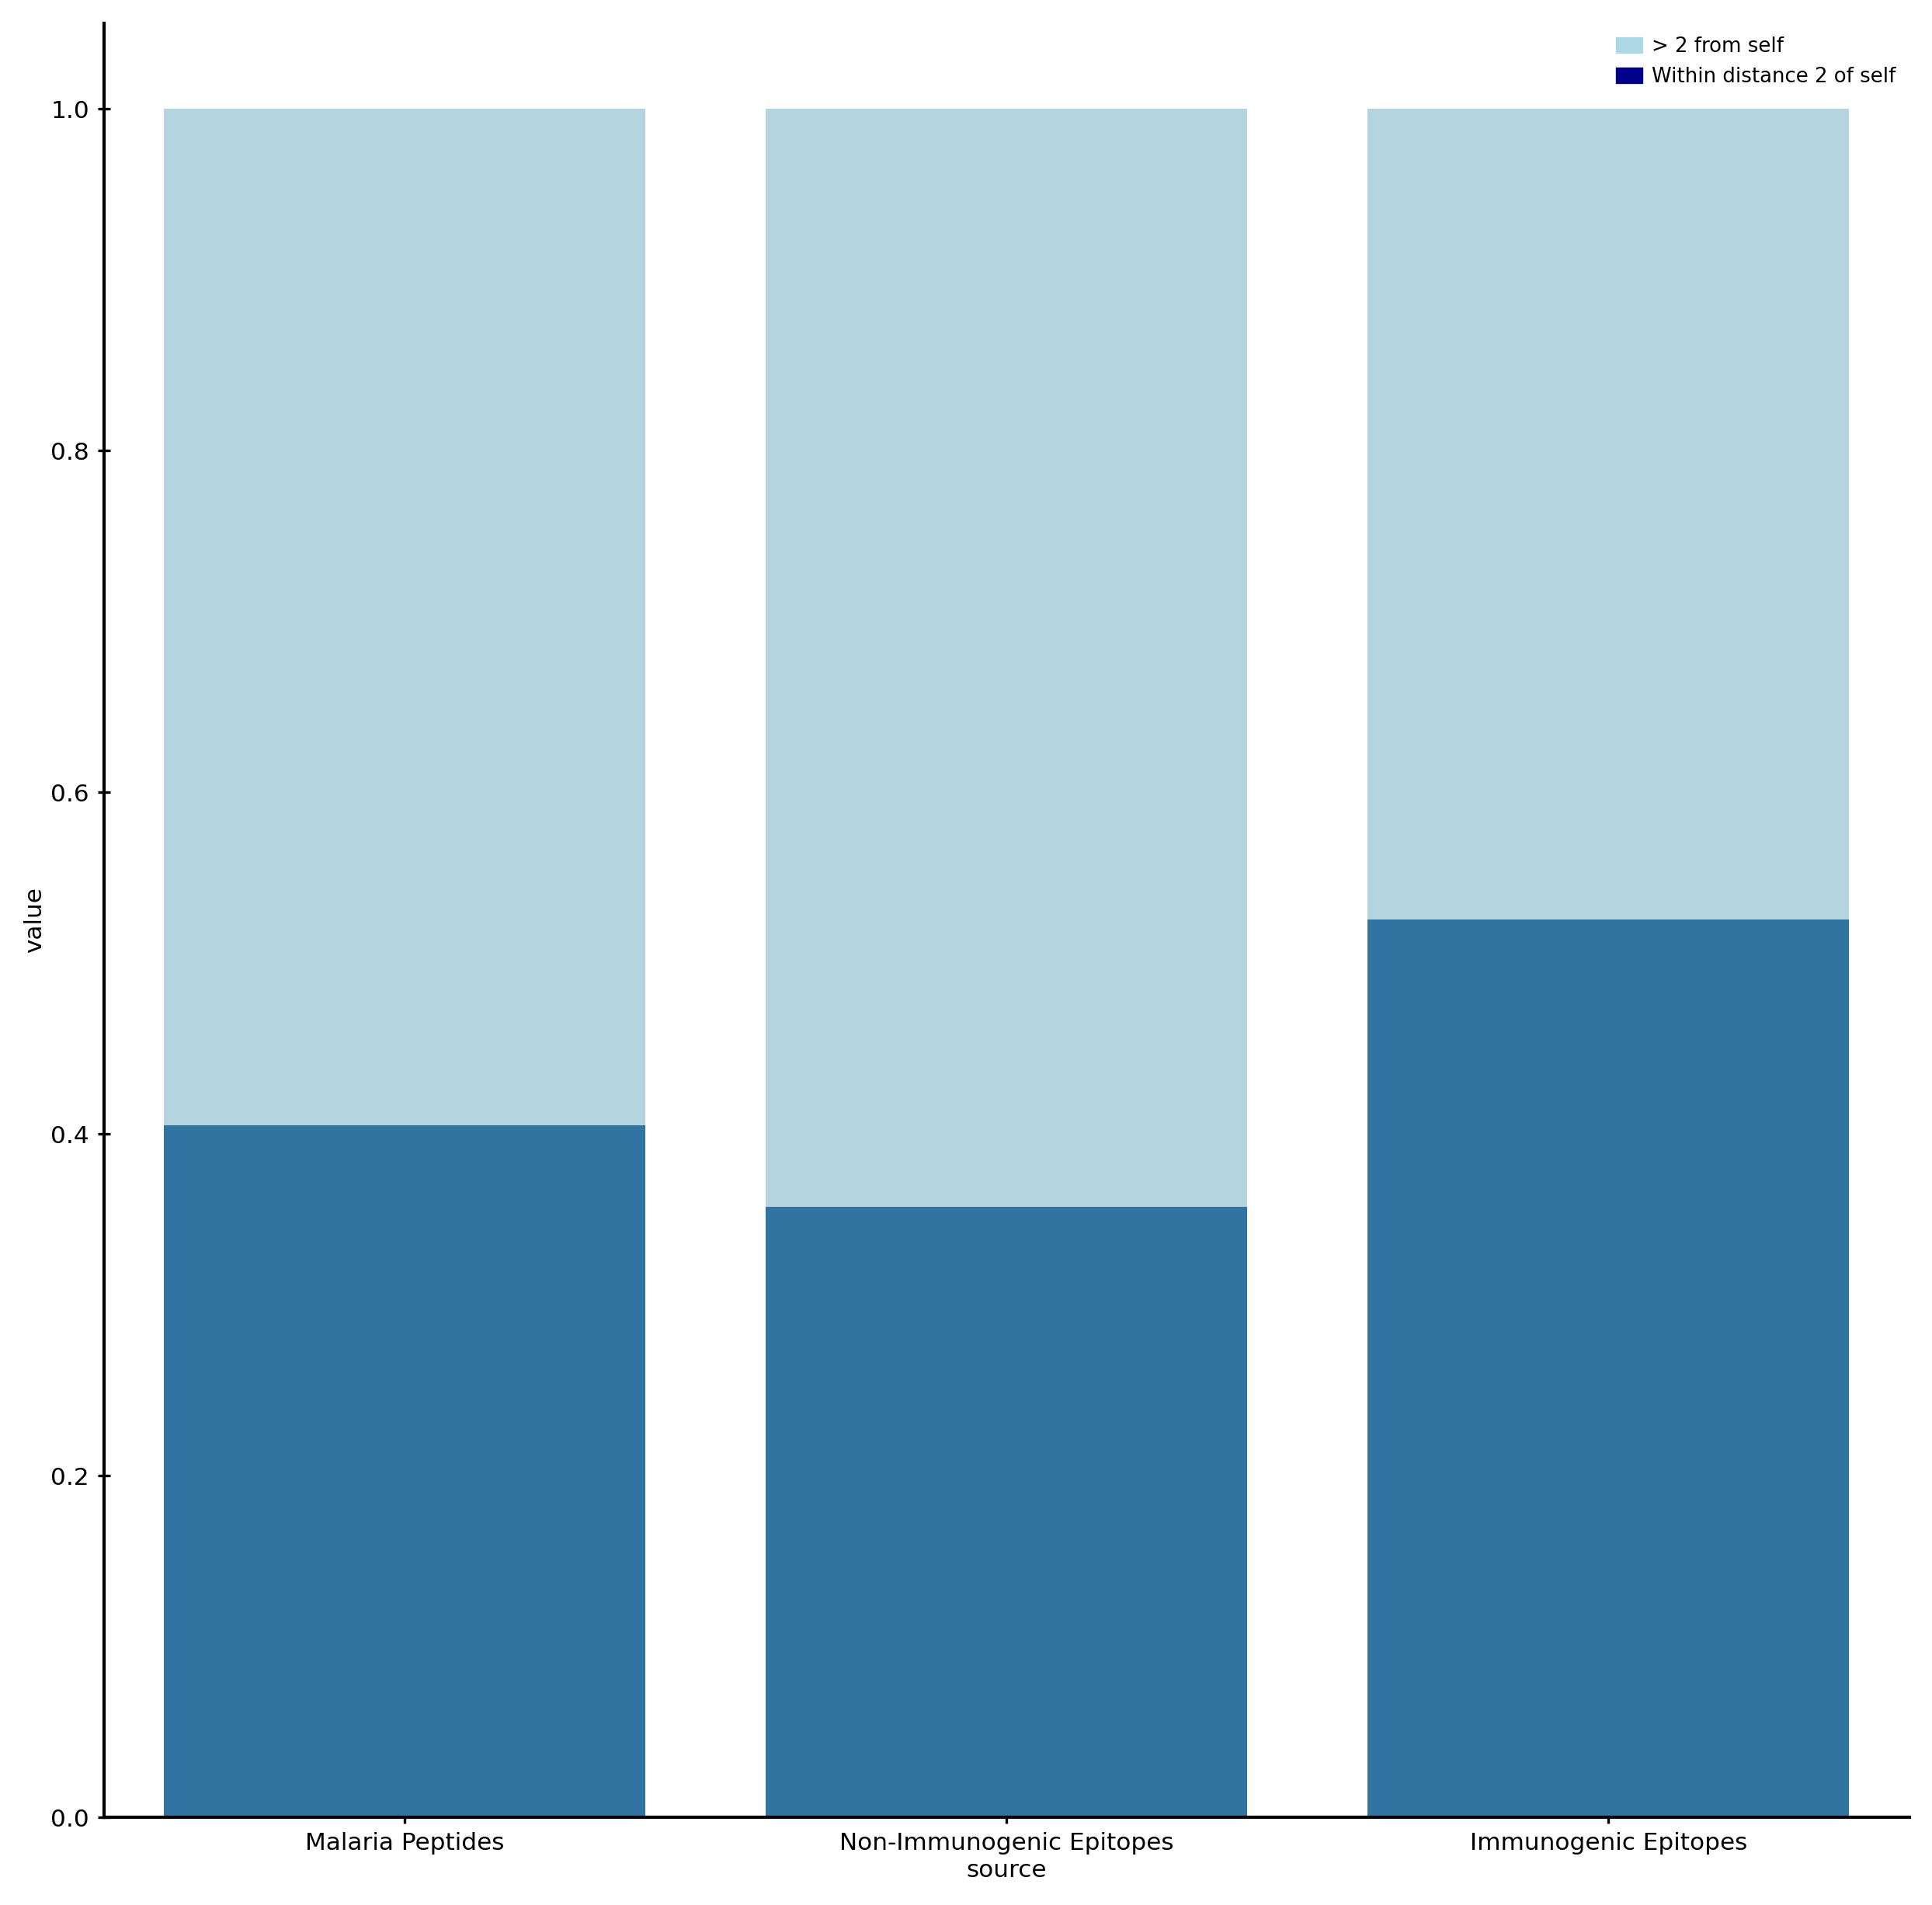

In [38]:
# not just ELISPOT


plt.figure(figsize=(10,10))
# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="source",  y="value", data=total_df, color='lightblue',order=list(source_mapper.values()))

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="source", y="value", data=close_to_self_df, color='#1f77b4',order=list(source_mapper.values()))

# add legend
bottom_bar = mpatches.Patch(color='darkblue', label='Within distance 2 of self')
top_bar = mpatches.Patch(color='lightblue', label='> 2 from self')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

In [40]:
epidist_df = pd.read_csv(f'{figdatadir}/epidist.csv',index_col='Epitope')

In [41]:
epidist_df

,Unnamed: 0,Immunogenic,nndist,distance
Epitope,,,,
AAAPVVESK,1,False,1,7.286114
AEFTVPKFL,21,False,1,1.715035
AEMLREEGY,30,True,1,1.101286
AESRKLLLI,37,True,1,9.362759
AKLDRLDEE,91,True,1,5.315721
...,...,...,...,...
YFIKHVLAF,5751,False,1,4.946858
YFKRLTSEI,5755,False,1,8.972305
YLFNAIETM,5832,False,1,0.625489


In [42]:
epidist_df.groupby(by=['Immunogenic']).max()

,Unnamed: 0,nndist,distance
Immunogenic,,,
False,6036,1,14.528155
True,5357,1,15.199967


KstestResult(statistic=np.float64(0.32775768535262206), pvalue=np.float64(0.01748919047183408), statistic_location=np.float64(4.333440028399616), statistic_sign=np.int8(-1))

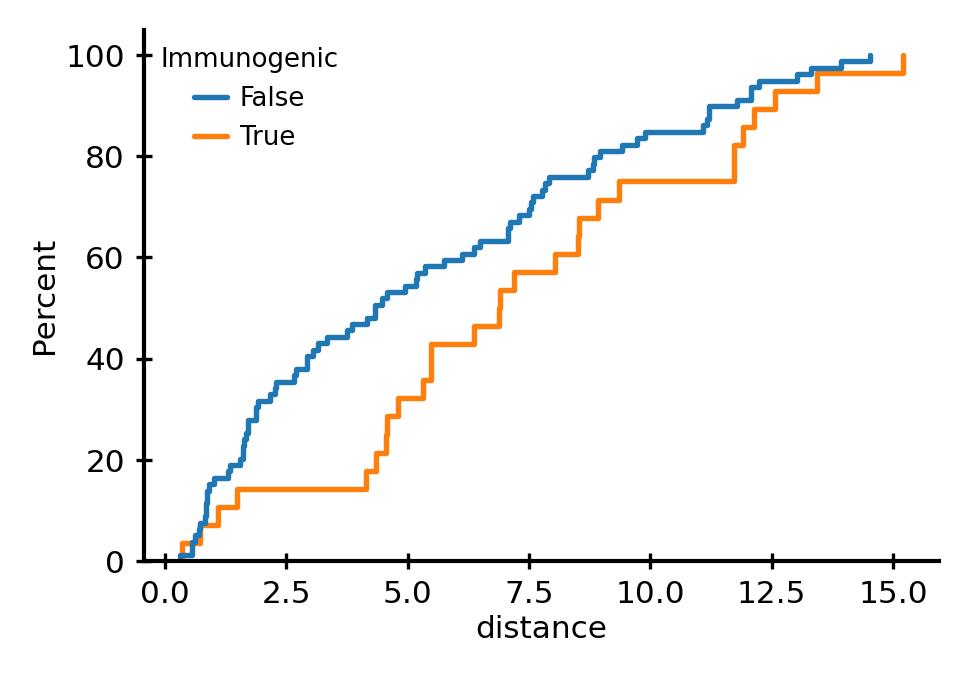

In [44]:
sns.ecdfplot(epidist_df,x="distance",hue='Immunogenic',stat='percent',complementary=False)
pos = epidist_df[epidist_df['Immunogenic']]['distance']
neg = epidist_df[~epidist_df['Immunogenic']]['distance']
scipy.stats.ks_2samp(pos,neg)

In [45]:
from matplotlib.table import Table
columns = ["Self Peptide", "P. Falciparum Epitope", "Cross-Reactivity Distance"]
data = [
    ["GAAGGLALL", "GIAGGLALL", "4.1"],
    ["VLAGLLGMV", "VLAGLLGNV", "6.1"],
    ["LGILSVSSF", "LAILSVSSF", "3.2"],
]

In [46]:
malaria_abundance_df = pd.read_csv(f'{figdatadir}/malaria_abundance.csv')

In [47]:
source_mapper = {
    'background': 'Malaria Peptides',
    'negative': 'Non-Immunogenic Epitopes',
    'positive': 'Immunogenic Epitopes',

}
malaria_abundance_df['source'] = malaria_abundance_df['source'].apply(source_mapper.get)

/tmp/ipykernel_4165927/1669965898.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(['All P. Falciparum\nPeptides','Non-Immunogenic\nP. Falciparum\nPeptides','Immunogenic\nP. Falciparum\nPeptides'],rotation=0,fontsize=9)
/tmp/ipykernel_4165927/1669965898.py:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(['All P. Falciparum\nPeptides','Non-Immunogenic\nP. Falciparum\nPeptides','Immunogenic\nP. Falciparum\nPeptides'],rotation=0,fontsize=9)


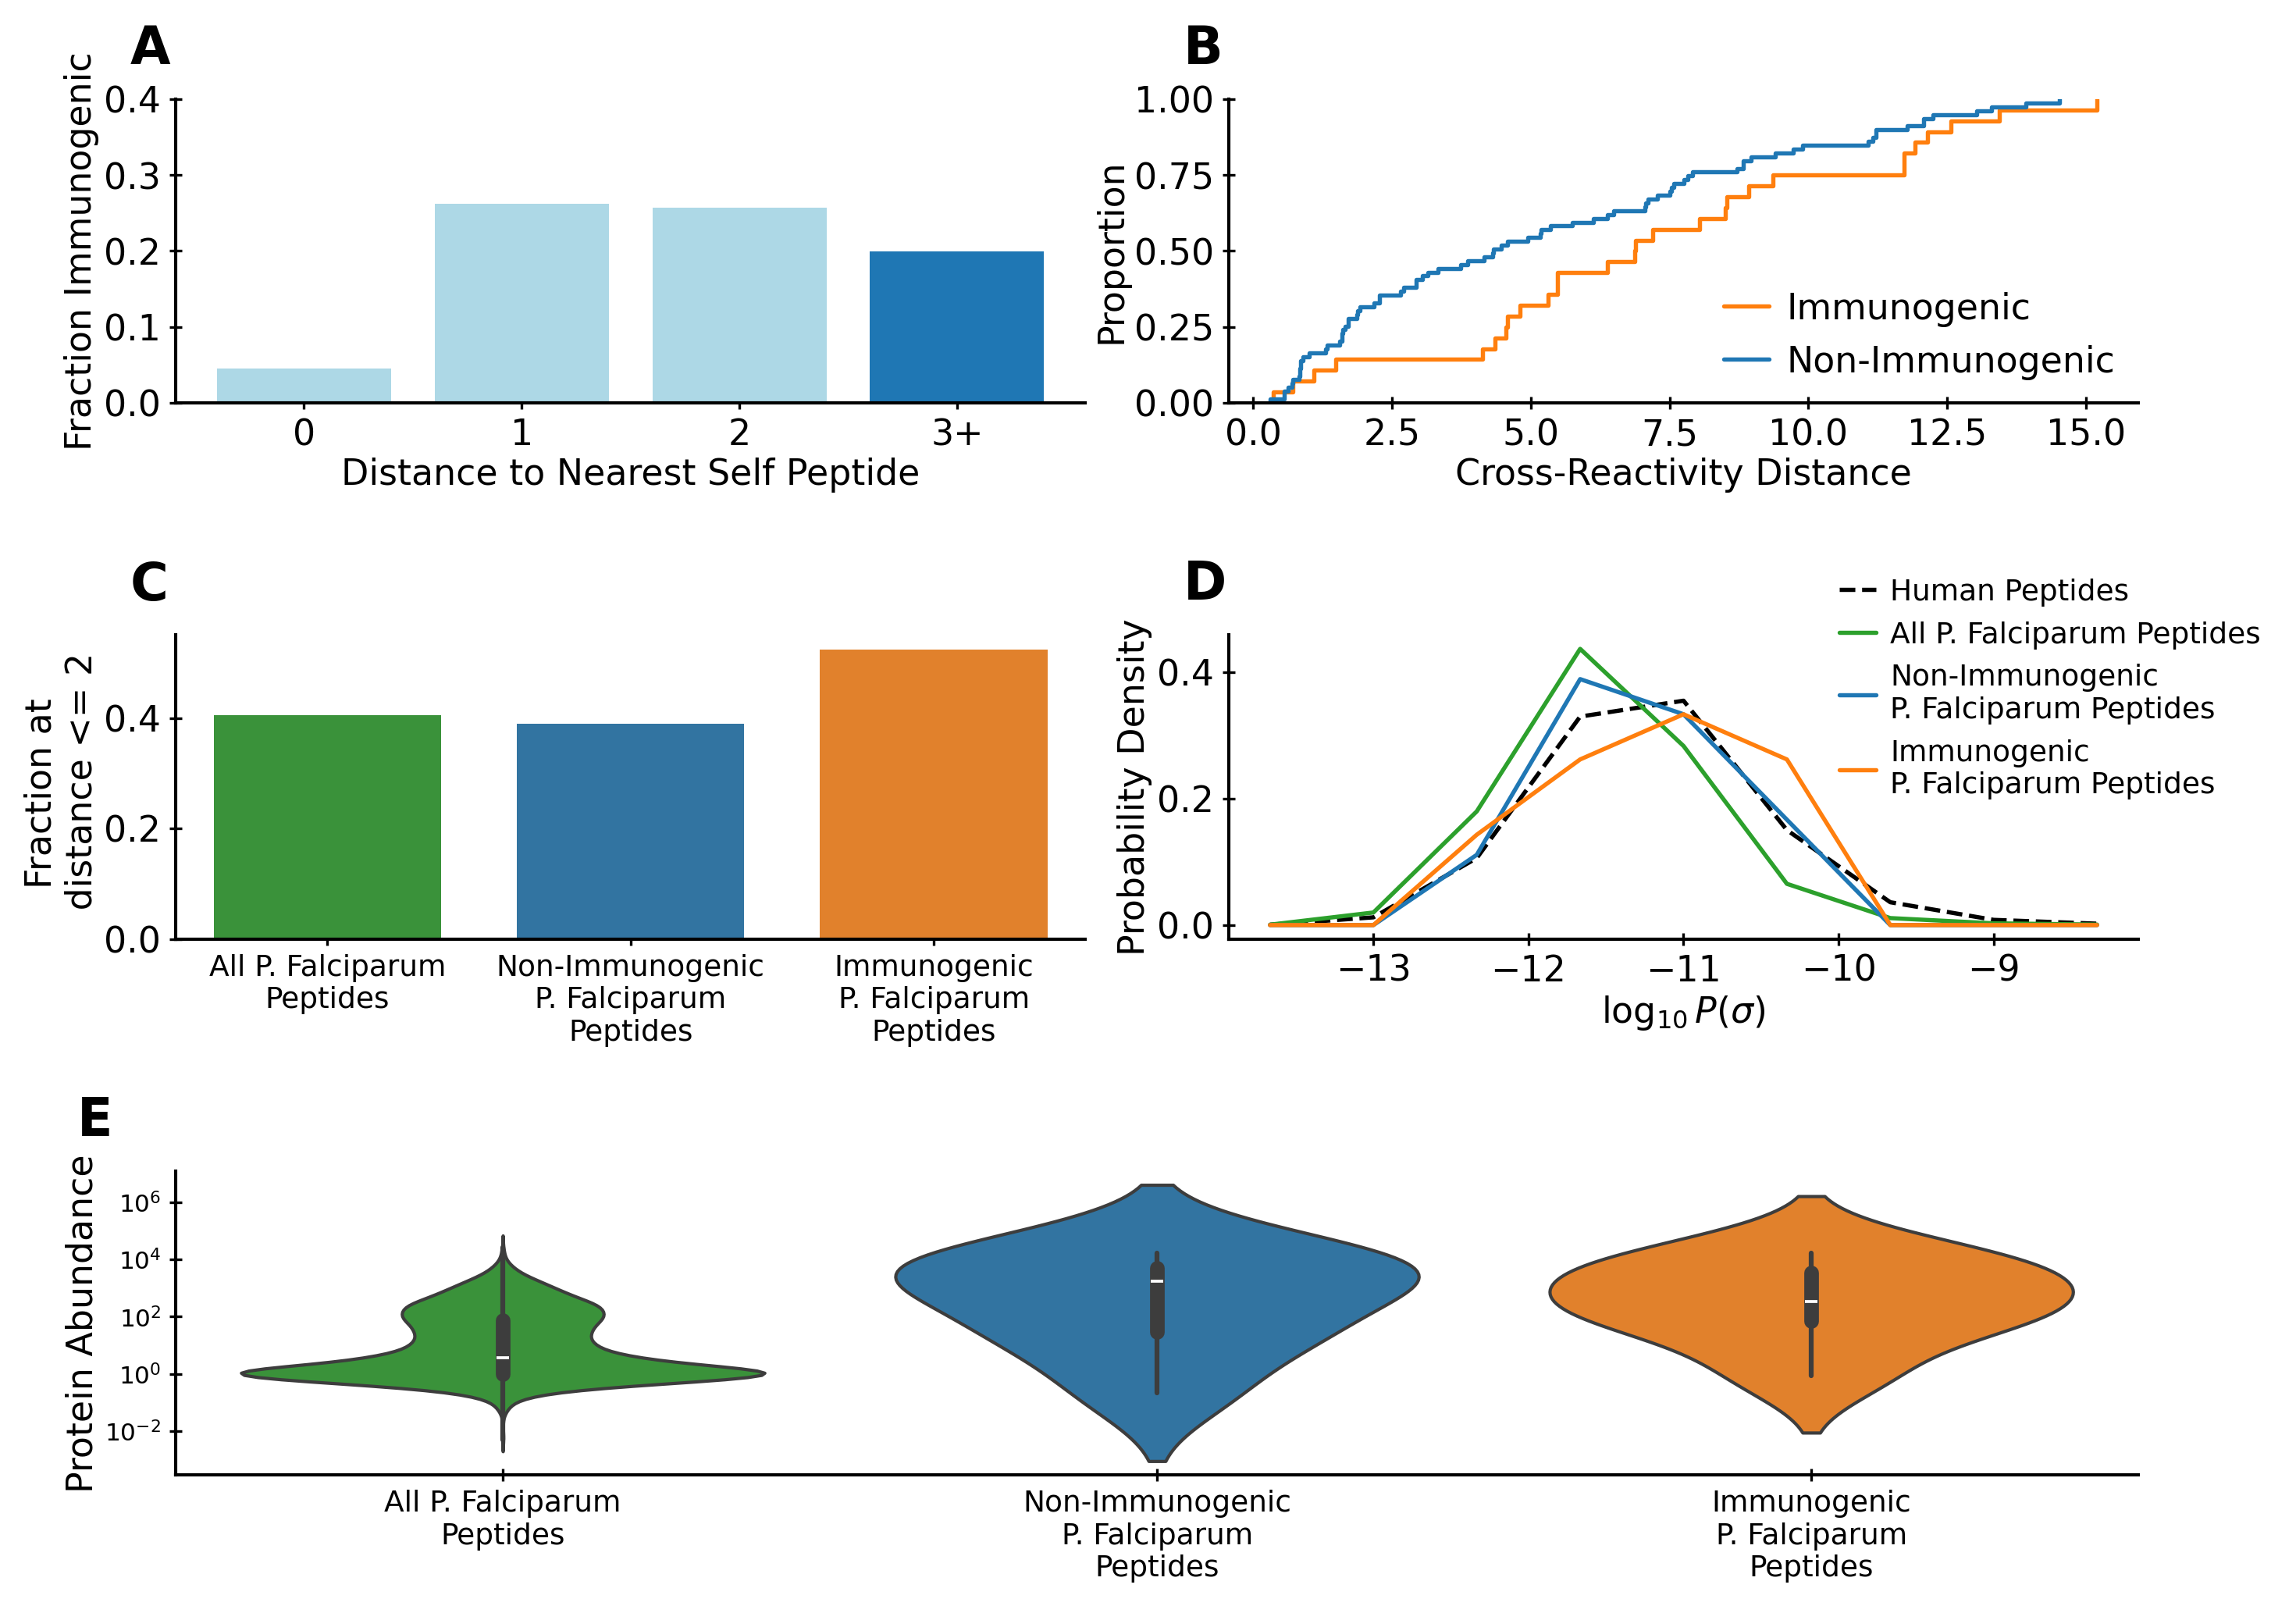

In [48]:
fig = plt.figure(figsize=(10, 7))

blue = '#1f77b4'
orange = '#ff7f0e'
green = '#2ca02c'

order_colors = {
 'Malaria Peptidome': green,
 'Malaria Epitopes (-)': blue,
 'Malaria Epitopes': orange
    
}
axfontsize = 11

# Define a GridSpec with 3 rows and 2 columns
gs = gridspec.GridSpec(3, 2)

# Create the first four subplots in a 2x2 grid
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Create the fifth subplot, spanning both columns of the third row
ax5 = fig.add_subplot(gs[2, :])
# ax6 = fig.add_subplot(gs[2, 1])


# lower, upper = statsmodels.stats.proportion.proportion_confint(ps*ns, ns, method='jeffreys', alpha=.1)
# ax1.errorbar(range(len(ps)), ps, yerr=[ps-lower, upper-ps], ls='None', fmt='o',ms=5)
# ax1.bar(range(len(ps)), ps,yerr=[lower,upper],capsize=1)
ax1.bar(range(len(ps)), ps,color=['lightblue','lightblue','lightblue', blue])

ax1.set_ylim(0.0, 0.40)
ax1.set_xlabel('Distance to Nearest Self Peptide',fontsize=axfontsize)
ax1.set_ylabel('Fraction Immunogenic',fontsize=axfontsize)
ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels([0, 1, 2, '3+'],fontsize=axfontsize)
ax1.yaxis.set_tick_params(labelsize=axfontsize)


# sns.swarmplot(data=epidist_df, x='Immunogenic', y='distance', ax=ax2, s=5,hue='Immunogenic',legend=False)
# sns.boxplot(data=epidist_df, x='Immunogenic', y='distance', color='white', showfliers=False, whis=0, ax=ax2)
sns.ecdfplot(epidist_df,x="distance",hue='Immunogenic',ax=ax2,legend=False)

ax2.legend(loc='lower right', labels=['Immunogenic', 'Non-Immunogenic'],fontsize=axfontsize)
ax2.set_xlabel('Cross-Reactivity Distance',fontsize=axfontsize)
ax2.set_ylabel('Proportion',fontsize=axfontsize)
ax2.yaxis.set_tick_params(labelsize=axfontsize)
ax2.xaxis.set_tick_params(labelsize=axfontsize)
# plt.setp(ax2.get_legend().get_texts(), fontsize=axfontsize)
# plt.setp(ax2.get_legend().get_title(), fontsize=axfontsize)


labels_dict = {
    'Human Peptidome': 'Human Peptides',
    'Malaria Peptidome': 'All P. Falciparum Peptides',
    'Malaria Epitopes': 'Immunogenic\nP. Falciparum Peptides',
    'Malaria Epitopes (-)': 'Non-Immunogenic\nP. Falciparum Peptides'
}

for dataset in order:
    bins = np.array(density_dict[dataset]['bins'])
    pdf = np.array(density_dict[dataset]['pdf'])
# density
    if dataset.startswith('Human'):
        ax4.plot(0.5*(bins[:-1]+bins[1:]), pdf ,'k--',label=labels_dict[dataset])
    else:
        ax4.plot(0.5*(bins[:-1]+bins[1:]), pdf ,color=order_colors[dataset],label=labels_dict[dataset])

ax4.set_xlabel(r'$\log_{10} P(\sigma)$',fontsize=axfontsize)
ax4.xaxis.set_tick_params(labelsize=axfontsize)
ax4.yaxis.set_tick_params(labelsize=axfontsize)

ax4.set_ylabel('Probability Density',fontsize=axfontsize)
ax4.legend(loc='upper left',bbox_to_anchor=(0.65,1.25),fontsize=axfontsize-2)

# sns.boxplot(abundance_results,x='source',y='value',log_scale=True)

# bar1 = sns.barplot(x="source",  y="value", width=.75,data=total_df, color='lightblue',order=list(source_mapper.values()),ax=ax3)
bar2 = sns.barplot(x="source", y="value", width=.75,
                   data=collapsed_df[collapsed_df['distance']=='<=2'],
                   hue_order=['Non-Immunogenic Epitopes', 'Immunogenic Epitopes', 'Malaria Peptides'],
                   hue="source",legend=False,order=list(source_mapper.values()),ax=ax3)

# add legend
# bottom_bar = mpatches.Patch(color='darkblue', label='dist <= 2')
# top_bar = mpatches.Patch(color='lightblue', label='dist > 2')
# ax3.legend(loc='center left',
#                bbox_to_anchor=(-.5,.75),
#                handles=[top_bar, bottom_bar],
#                title='Distance to Nearest\n    Self Peptide\n',
#                fontsize=axfontsize,
#                title_fontproperties={'weight': 'bold','size': 'small'},
#               frameon=False)
ax3.set_xticklabels(['All P. Falciparum\nPeptides','Non-Immunogenic\nP. Falciparum\nPeptides','Immunogenic\nP. Falciparum\nPeptides'],rotation=0,fontsize=9)

ax3.set_xlabel('')
ax3.set_ylabel('Fraction at \n distance <= 2',fontsize=axfontsize)
# axes[1].legend(loc='upper right',bbox_to_anchor=(.5,1.55))

ax3.yaxis.set_tick_params(labelsize=axfontsize)

sns.violinplot(data=malaria_abundance_df, x='source',
               y='value', ax=ax5,hue='source',
               legend=False,log_scale=True,
               hue_order=['Immunogenic Epitopes', 'Non-Immunogenic Epitopes', 'Malaria Peptides'])
# sns.boxplot(data=malaria_abundance_df, x='source', y='value', color='white', showfliers=False, whis=0, ax=ax4,log_scale=True)
ax5.set_xlabel('')
ax5.set_ylabel('Protein Abundance',fontsize=axfontsize)
ax5.set_xticklabels(['All P. Falciparum\nPeptides','Non-Immunogenic\nP. Falciparum\nPeptides','Immunogenic\nP. Falciparum\nPeptides'],rotation=0,fontsize=9)


# ax6.set_axis_off()  # Turn off the axis

# # Create the table
# table = Table(ax6, bbox=[0, 0, 1, 1])
# table.FONTSIZE=24
# for col_idx, col_name in enumerate(columns):
#     table.add_cell(0, col_idx, width=0.2, height=0.2, text=col_name, loc='center', facecolor='lightgray')

# for row_idx, row_data in enumerate(data, start=1):
#     for col_idx, cell_data in enumerate(row_data):
#         table.add_cell(row_idx, col_idx, width=0.2, height=0.2, text=cell_data, loc='center', facecolor='white')

# ax6.add_table(table)


label_axes(fig,labelstyle='%s', xy=(-0.05, 1.25),fontsize=16)
fig.tight_layout()
# plt.savefig('../fig4_updated.png')
# plt.savefig('../fig4_updated.svg')


In [49]:
m_abundance = malaria_abundance_df[malaria_abundance_df['source']=='Malaria Peptides']['value']
p_abundance = malaria_abundance_df[malaria_abundance_df['source']=='Non-Immunogenic Epitopes']['value']
n_abundance = malaria_abundance_df[malaria_abundance_df['source']=='Immunogenic Epitopes']['value']


In [50]:
scipy.stats.mannwhitneyu(np.array(m_abundance), np.array(p_abundance))

MannwhitneyuResult(statistic=np.float64(7180.5), pvalue=np.float64(0.006965592217913208))

In [51]:
scipy.stats.mannwhitneyu(np.array(m_abundance), np.array(n_abundance))

MannwhitneyuResult(statistic=np.float64(8306.5), pvalue=np.float64(0.016233260124247025))

In [52]:
scipy.stats.mannwhitneyu(np.array(p_abundance), np.array(n_abundance))

MannwhitneyuResult(statistic=np.float64(25.0), pvalue=np.float64(1.0))